In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [5]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3'
datasets_loc = []
datasets_loc += glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

In [6]:
tree = rt.TChain('outA/Tevts')

for floc in datasets_loc:
    tree.Add(floc)

print 'N evts: {:.0f}'.format(tree.GetEntries())

N evts: 530076


# Cuts declaration

In [7]:
cut_general = [
    'n_B == 1'
]

# Muon system

In [27]:
cut_mumu = [
####----- Trigger-like cuts -----#
'mum_pt > 3.5',
'mup_pt > 3.5',
'Jpsi_pt > 4.5',
# 'sigdxy_vtxJpsi_PV > 3', #useless
'pval_mumu > 0.1',
'mum_eta > -2.2',
'mup_eta > -2.2',
'mum_eta < 2.2',
'mup_eta < 2.2',
'cosT_Jpsi_PV > 0.95',
####----- Muon systems cuts -----#
'mum_dxy < 3',
'mup_dxy < 3',
]

In [28]:
cut_str = ' && '.join(cut_general + cut_mumu)
print cut_str

n_B == 1 && mum_pt > 3.5 && mup_pt > 3.5 && Jpsi_pt > 6.9 && pval_mumu > 0.1 && mum_eta > -2.2 && mup_eta > -2.2 && mum_eta < 2.2 && mup_eta < 2.2 && cosT_Jpsi_PV > 0.95 && mum_dxy < 3 && mup_dxy < 3


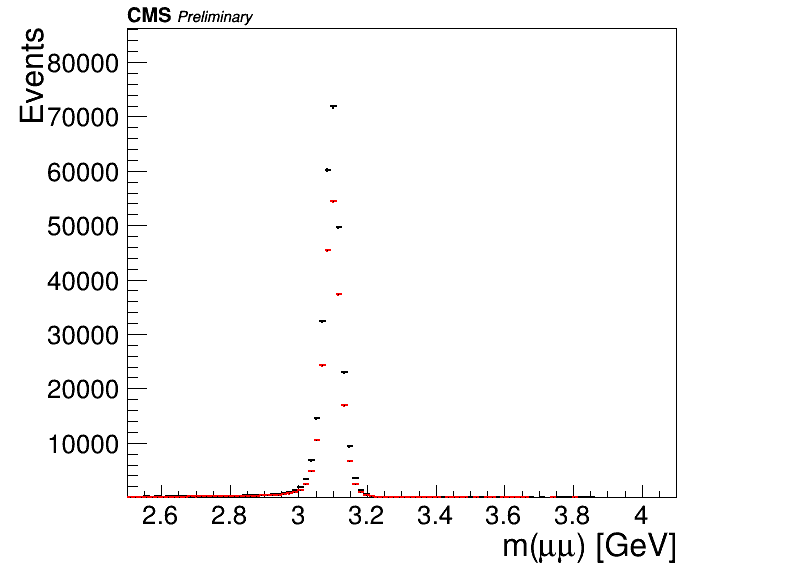

In [21]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[100, 2.5, 4.1]
               )
tree.Project('h', 'mass_mumu', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_mumu', cut_str + ' && pval_mumupiK > 0.1')
h2.Sumw2()
h2.SetLineColor(rt.kRed)

c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

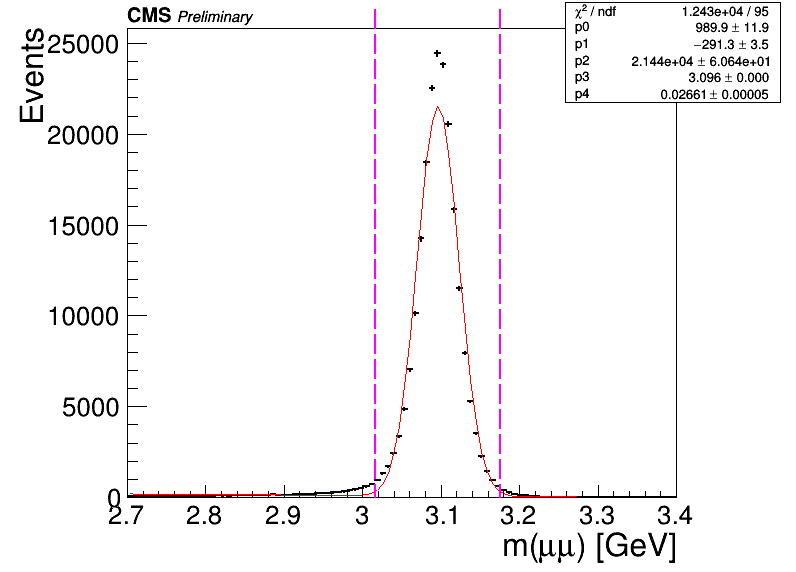

In [22]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[100, 2.7, 3.4]
               )
tree.Project('h', 'mass_mumu', cut_str + ' && pval_mumupiK > 0.1')
h.Sumw2()
f_fit = rt.TF1('f_fit', '[0] + x*[1] + gaus(2)', 2.7,3.4)
f_fit.SetParameter(0, h.GetBinContent(1))
f_fit.SetParameter(1, (h.GetBinContent(100) - h.GetBinContent(1))/(h.binning[2] - h.binning[1]))
f_fit.SetParameter(2, h.GetMaximum())
f_fit.SetParameter(3, 3.1)
f_fit.SetParameter(4, 0.05)
h.Fit(f_fit, 'LSRQ')

m_mumu_min = f_fit.GetParameter(3) - 3*f_fit.GetParameter(4)
m_mumu_max = f_fit.GetParameter(3) + 3*f_fit.GetParameter(4)

c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
cl.DrawLine(m_mumu_min, 0, m_mumu_min, 1.1*h.GetMaximum())
cl.DrawLine(m_mumu_max, 0, m_mumu_max, 1.1*h.GetMaximum())
c.Draw()

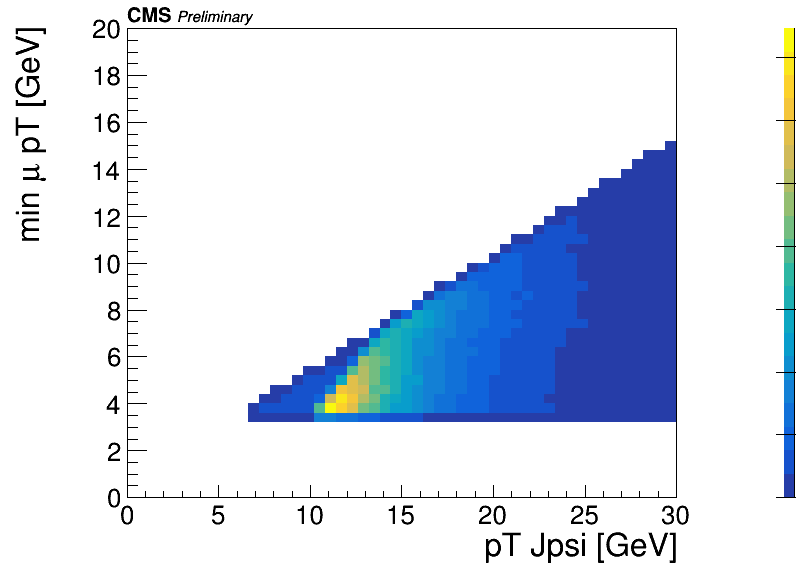

In [29]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['pT Jpsi [GeV]', 'min #mu pT [GeV]', 'Events'],
                binning=[50, 0, 30, 50, 0., 20]
               )
tree.Project('h', 'min(mum_pt, mup_pt):Jpsi_pt', cut_str)
h.Sumw2()


                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

# Hadron system

In [8]:
cut_piK = [
####----- Hadron systems cuts -----#
'K_pt > 0.8',
'pi_pt > 0.8',
'K_sigdxy_PV > 2',
'pi_sigdxy_PV > 2',
'pval_piK > 0.1'
]

In [9]:
cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && K_pt > 0.8 && pi_pt > 0.8 && K_sigdxy_PV > 2 && pi_sigdxy_PV > 2 && pval_piK > 0.1


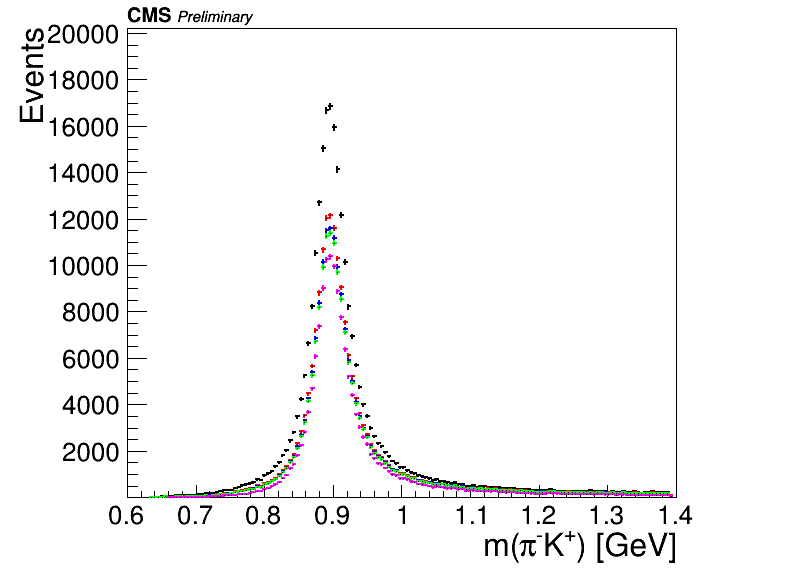

In [10]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[150, 0.6, 1.4]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && sigd_vtxKst_PV > 5')
h2.Sumw2()
h2.SetLineColor(rt.kRed)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tree.Project('h3', 'mass_piK', cut_str + ' && sigdxy_vtxKst_PV > 5')
h3.Sumw2()
h3.SetLineColor(rt.kBlue)

h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
tree.Project('h4', 'mass_piK', cut_str + ' && sigd_vtxKst_PV > 5 && sigdxy_vtxKst_PV > 5')
h4.Sumw2()
h4.SetLineColor(rt.kGreen)

h5 = create_TH1D(np.zeros(0), name='h5', binning=h.binning)
tree.Project('h5', 'mass_piK', cut_str + ' && sigd_vtxKst_PV > 5 && sigdxy_vtxKst_PV > 5 && pval_mumupiK > 0.1')
h5.Sumw2()
h5.SetLineColor(rt.kMagenta)

c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3, h4, h5], 'same')
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

In [11]:
cut_piK += [
    'sigdxy_vtxKst_PV > 5',
    'pval_mumupiK > 0.1'
]
cut_piK = list(dict.fromkeys(cut_piK))

cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && pval_piK > 0.1 && K_pt > 0.8 && K_sigdxy_PV > 2 && pi_sigdxy_PV > 2 && sigdxy_vtxKst_PV > 5 && pval_mumupiK > 0.1 && pi_pt > 0.8


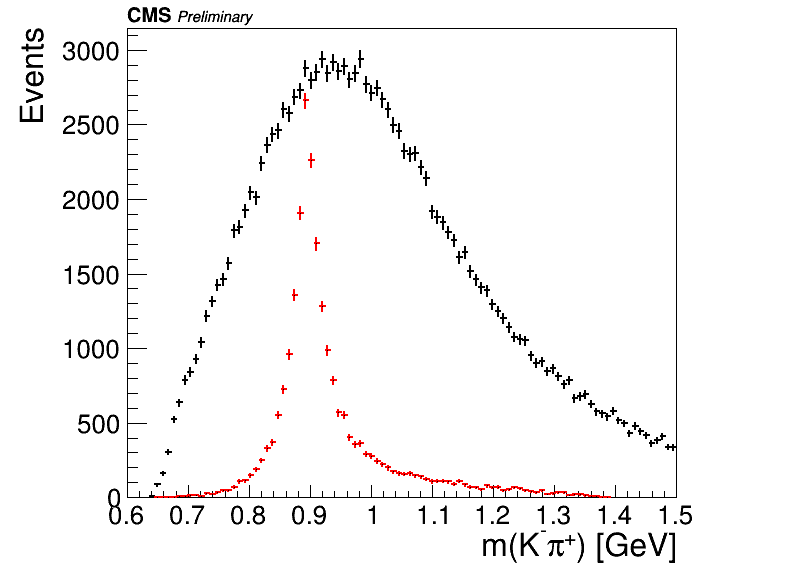

In [12]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(K^{-}#pi^{+}) [GeV]', 'Events'],
                binning=[100, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK_CPconj', cut_str)
h.Sumw2()

wrongCP_cut = 'fabs(mass_piK - 0.895) > fabs(mass_piK_CPconj - 0.895)'
h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK_CPconj', cut_str + ' && ' + wrongCP_cut)
h2.Sumw2()
h2.SetLineColor(rt.kRed)


                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

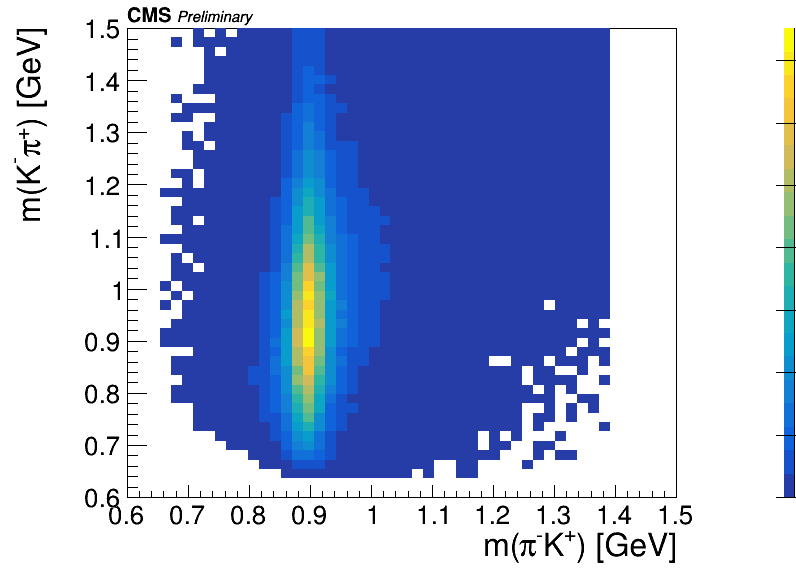

In [13]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'm(K^{-}#pi^{+}) [GeV]', 'Events'],
                binning=[50, 0.6, 1.5, 50, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK_CPconj:mass_piK', cut_str)
h.Sumw2()


                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

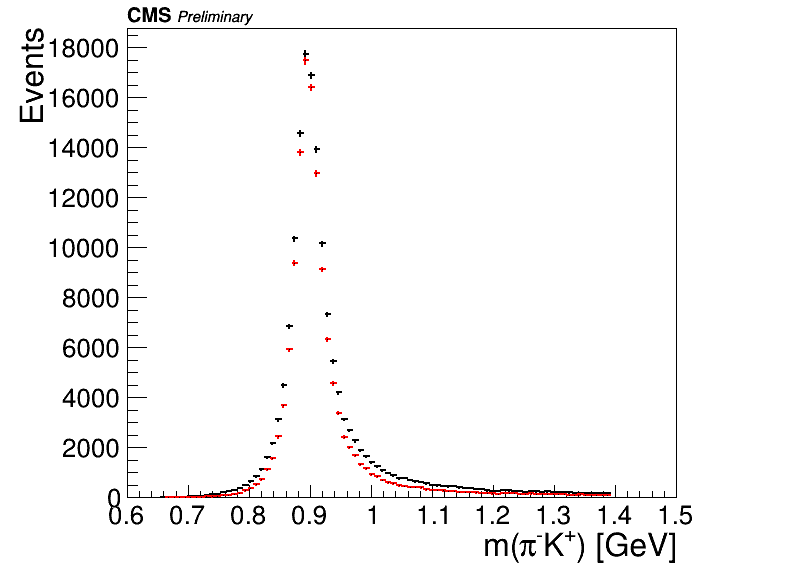

In [14]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

correctCP_cut = 'fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)'
h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && ' + correctCP_cut)
h2.Sumw2()
h2.SetLineColor(rt.kRed)


                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

In [15]:
cut_piK += ['fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)']
cut_piK = list(dict.fromkeys(cut_piK))

cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && pval_piK > 0.1 && K_pt > 0.8 && K_sigdxy_PV > 2 && pi_sigdxy_PV > 2 && sigdxy_vtxKst_PV > 5 && fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895) && pval_mumupiK > 0.1 && pi_pt > 0.8


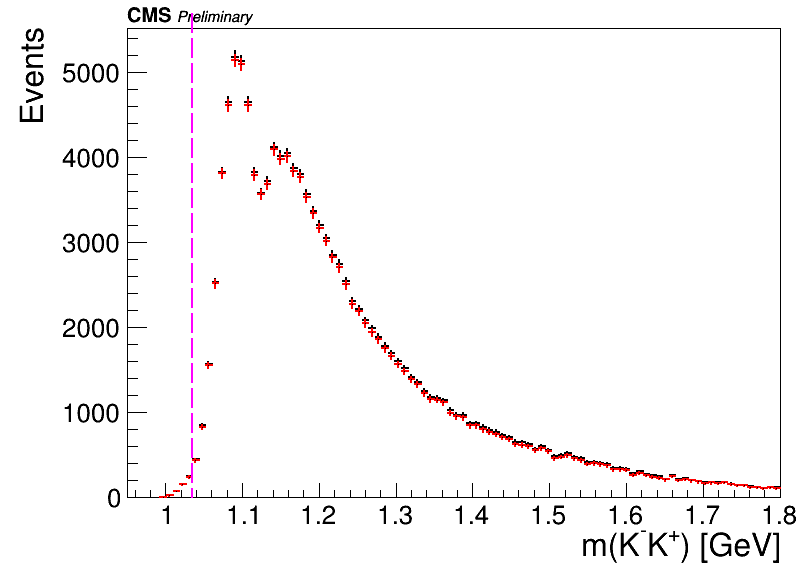

In [18]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(K^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 0.95, 1.8]
               )
tree.Project('h', 'mass_KK', cut_str)
h.Sumw2()

sel = 'abs(MC_K_pt - K_pt)/MC_K_pt < 0.1 && abs(MC_K_eta - K_eta) < 0.05'
h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_KK', cut_str + ' && ' + sel)
h2.Sumw2()
h2.SetLineColor(rt.kRed)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
cl.DrawLine(1.035, 0, 1.035, 1.1*h.GetMaximum())
c.Draw()

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 0.6, 1.5]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && mass_KK > 1.035')
h2.Sumw2()
h2.SetLineColor(rt.kRed)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.Draw()

In [ ]:
cut_piK += ['mass_KK > 1.035']
cut_piK = list(dict.fromkeys(cut_piK))
print cut_piK

# Full analysis

In [ ]:
cut_B = [
    'mass_mumu < {:.3f}'.format(m_mumu_max),
    'mass_mumu > {:.3f}'.format(m_mumu_min),
    'mass_piK > 0.82',
    'mass_piK < 0.96'
        ]
cut_B += cut_mumu + cut_piK
print cut_B

cut_str = ' && '.join(cut_general + cut_B)

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 4.3, 6]
               )
tree.Project('h', 'mass_mumupiK', cut_str)
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[50, 3, 3.2]
               )
tree.Project('h', 'mass_mumu', cut_str + ' && mass_mumupiK < 5.45 && mass_mumupiK > 5.15')
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[50, 0.82, 0.96]
               )
tree.Project('h', 'mass_piK', cut_str + ' && mass_mumupiK < 5.45 && mass_mumupiK > 5.15')
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'vtx displacement significance', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 100]
               )
tree.Project('h', 'sigd_vtxB_PV_mumupiK:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'pointing to PV', 'Events'],
                binning=[100, 4.3, 6, 50, -1, 1]
               )
tree.Project('h', 'cos_B_PV_mumupiK:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'p-value', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 1]
               )
tree.Project('h', 'pval_mumupiK:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'p-value', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 1]
               )
tree.Project('h', 'pval_mumupiKrefit:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'pT_{B}', 'Events'],
                binning=[100, 4.3, 6, 50, 0, 50]
               )
tree.Project('h', 'B_mumupiK_pt:mass_mumupiK', cut_str)
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()

# Signal isolation

In [ ]:
cut_str = ' && '.join(cut_B)
# cut_str = ' && '.join(cut_general + cut_B)

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[100, 5.1, 5.4]
               )
tree.Project('h', 'mass_mumupiK', cut_str)
h.Sumw2()

In [ ]:
# tf = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst.root', 'r')
# skimmed_tree = tf.Get('Tevts')
# h = create_TH1D(np.zeros(0), name='h',
#                 title='',
#                 axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
#                 binning=[30, 5, 5.6]
#                )
# skimmed_tree.Project('h', 'mass_mumupiK')
# h.Sumw2()

In [ ]:
N_tot = h.Integral(1, h.binning[0])
print N_tot
print h.Integral()

In [ ]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[1], h.binning[2], 'GeV')
frame = mass.frame(rf.Title(""))

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
mean2 = rt.RooRealVar('mean', '#mu', m_B0-0.01, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{W}', 0.02, 0.00005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{N}', 0.2, 0.00005, 0.5, 'GeV') 
gausN = rt.RooGaussian('gausNarrow','gN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausWide','gW', mass, mean2, sigmaW)

fN = rt.RooRealVar('fraction', 'f', 0.5, 0, 1, '')
pdf_sig = rt.RooAddPdf('pdf_sig', 'pdf_sig', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = pdf_sig_ext
pdf_tot.fitTo(data, rt.RooFit.PrintLevel(-1))

chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
if chi2.getVal() > rt.TMath.ChisquareQuantile(0.95, h.binning[0]-1-5):
    print '[WARNING] Chi2:', chi2.getVal(), '/', h.binning[0]-1-5


data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))


c = drawOnCMSCanvas(CMS_lumi, frame)
m = mean.getVal()
res = sigma.getVal()
cl.SetLineColor(rt.kMagenta)
cl.DrawLine(m-3*res, 0, m-3*res, h.GetMaximum())
cl.DrawLine(m+3*res, 0, m+3*res, h.GetMaximum())

cl.SetLineColor(rt.kYellow+1)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum())

# c.SetLogy()